In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt # Visualization
import warnings # Supress warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model

In [54]:
df = pd.read_csv("./files/interploated_m.csv", index_col=0)
df.index = pd.to_datetime(df.index, format = '%Y-%m-%d')
df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2009-01-31,6.3,-30.503871,4.964516,-827548.704,2.387097
2009-02-28,14.0,-29.350000,5.125000,-717952.896,2.546429
2009-03-31,34.2,-28.502903,9.254839,-879621.120,2.490323
2009-04-30,16.3,-27.736333,13.806667,-845030.016,2.403333
2009-05-31,28.6,-27.478065,19.809677,-997805.952,2.109677
...,...,...,...,...,...
2020-02-29,18.6,-25.261724,8.989655,-822268.800,2.420690
2020-03-31,70.2,-24.945355,9.758065,-830281.536,2.722581
2020-04-30,41.6,-24.805133,14.016667,-739037.952,2.500000


In [55]:
WINDOW_SIZE = 5
TRAIN_SIZE = int((len(df.index)-5) * 0.4)
VAL_SIZE = int((len(df.index)-5) * 0.3)
print(TRAIN_SIZE, VAL_SIZE)

53 39


In [14]:
def init_model():
    model = Sequential()
    model.add(InputLayer((5, 1)))
    model.add(SimpleRNN(64))
    tf.keras.layers.Dropout(0.2),
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, 'linear'))
    model.summary()
    return model

In [6]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
def get_sets(series):
    X1, y1 = df_to_X_y(series, WINDOW_SIZE)
    X_train1, y_train1 = X1[:TRAIN_SIZE], y1[:TRAIN_SIZE]
    X_val1, y_val1 = X1[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE], y1[TRAIN_SIZE:TRAIN_SIZE + VAL_SIZE]
    X_test1, y_test1 = X1[TRAIN_SIZE + VAL_SIZE:], y1[TRAIN_SIZE + VAL_SIZE:]
    return X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1

In [8]:
def train_model(series, checkpoint):
    X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = get_sets(series)
    model = init_model()
    cp1 = ModelCheckpoint('C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\RNN_models\\'+checkpoint, save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=30, callbacks=[cp1])
    return model

In [9]:
def model_predict(series, checkpoint):
    model = load_model('C:\\Users\\poeppelmann\\DataspellProjects\\dsProject\\RNN_models\\'+checkpoint)
    X1, y1, X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = get_sets(series)
    #train_predictions = model.predict(X_train1).flatten()
    #val_predictions = model.predict(X_val1).flatten()
    #predictions = np.concatenate((train_predictions, val_predictions, test_predictions))
    #results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y1}, index=df.index[5:])
    #results.to_csv('predictions/'+name)
    predictions = pd.Series(model.predict(X_test1).flatten())
    predictions.name = series.name
    predictions.index = df.index[TRAIN_SIZE+VAL_SIZE+5:]
    return predictions

In [ ]:
column = 'Drainage_Volume'
series = df[column]
num=3
checkpoint = str(num)+'\\'+column

train_model(series, checkpoint)
result = model_predict(series, checkpoint)

In [147]:
result

Date
2017-01-19   -80.332848
2017-01-20   -80.332848
2017-01-21   -80.332848
2017-01-22   -80.332848
2017-01-23   -80.332848
                ...    
2020-06-26   -80.332848
2020-06-27   -80.332848
2020-06-28   -80.332848
2020-06-29   -80.332848
2020-06-30   -80.332848
Name: Drainage_Volume, Length: 1259, dtype: float32

In [56]:
result_list = []
num=3
for column in df.columns:
    checkpoint = str(num)+'\\'+column
    series = df[column]
    train_model(series,checkpoint)
    result = model_predict(series, checkpoint)
    result_list.append(result)
combined_dataframe = pd.concat(result_list, axis=1)
combined_dataframe.to_csv('predictions/RNN/'+str(num)+'.csv')

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_25 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_50 (Dense)            (None, 8)                 520       
                                                                 
 dense_51 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,753
Trainable params: 4,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2/2 [==============================] - 6s 5s/step - loss: 1133.3516 - root_mean_squared_error: 33.6653 - val_loss: 5959.7837 - val_root_mean_squared_error: 77.1996
Epoch 2/30
2/2 [==============================] - 4s 4s/step - loss: 1108.4919 - root_mean_squared_error: 33.2940 - val_loss: 5901.7188 - va

In [57]:
combined_dataframe

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
Date,,,,,
2017-02-28,13.177502,-9.928210,7.867377,-1.741314,2.551657
2017-03-31,13.347924,-9.948645,8.993202,-1.741314,2.552398
2017-04-30,13.298184,-9.954883,9.259146,-1.741314,2.564371
2017-05-31,13.336901,-9.971769,9.249164,-1.741314,2.567603
2017-06-30,13.350677,-9.955432,9.252815,-1.741314,2.559761
2017-07-31,14.022616,-9.855777,9.225208,-1.741314,2.566175
2017-08-31,14.480371,-9.807039,9.227945,-1.741314,2.558400
2017-09-30,14.476430,-9.737975,9.211042,-1.741314,2.539896
2017-10-31,13.125475,-9.733645,9.287292,-1.741314,2.523998


In [58]:
saved_df = combined_dataframe

In [59]:
metrics = {}
def calc_metrics(name, saved_df):

    results = pd.DataFrame(data={'Predictions':saved_df[name], 'Actuals':df[name]}, index=saved_df.index)

    # Step 2: Calculate the differences between the predicted and actual values
    results['Difference'] = results['Actuals'] - results['Predictions']

    # Step 3: Calculate squared differences for RMSE
    results['Squared_difference'] = results['Difference'] ** 2

    # Step 4: Calculate absolute differences for MAE and MAPE
    results['Absolute_difference'] = np.abs(results['Difference'])
    results['Absolute_percentage_difference'] = np.abs(results['Difference'] / results['Actuals'])

    # Step 5: Compute the metrics
    rmse = np.sqrt(results['Squared_difference'].mean())
    mae = results['Absolute_difference'].mean()
    mape = results['Absolute_percentage_difference'].mean() * 100  # to get the percentage
    return rmse, mae, mape

for column in df.columns:

    rmse, mae, mape = calc_metrics(column, saved_df)
    metrics[column] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('metrics/RNN/'+str(num)+'.csv')
metrics_df

,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
RMSE,61.215371,15.704348,9.530670,832782.862985,0.266005
MAE,46.386308,15.653366,7.468101,829572.526393,0.220319
MAPE,70.478987,61.367304,43.686000,99.999788,8.664265


In [60]:
import winsound
winsound.Beep(2500,1000)

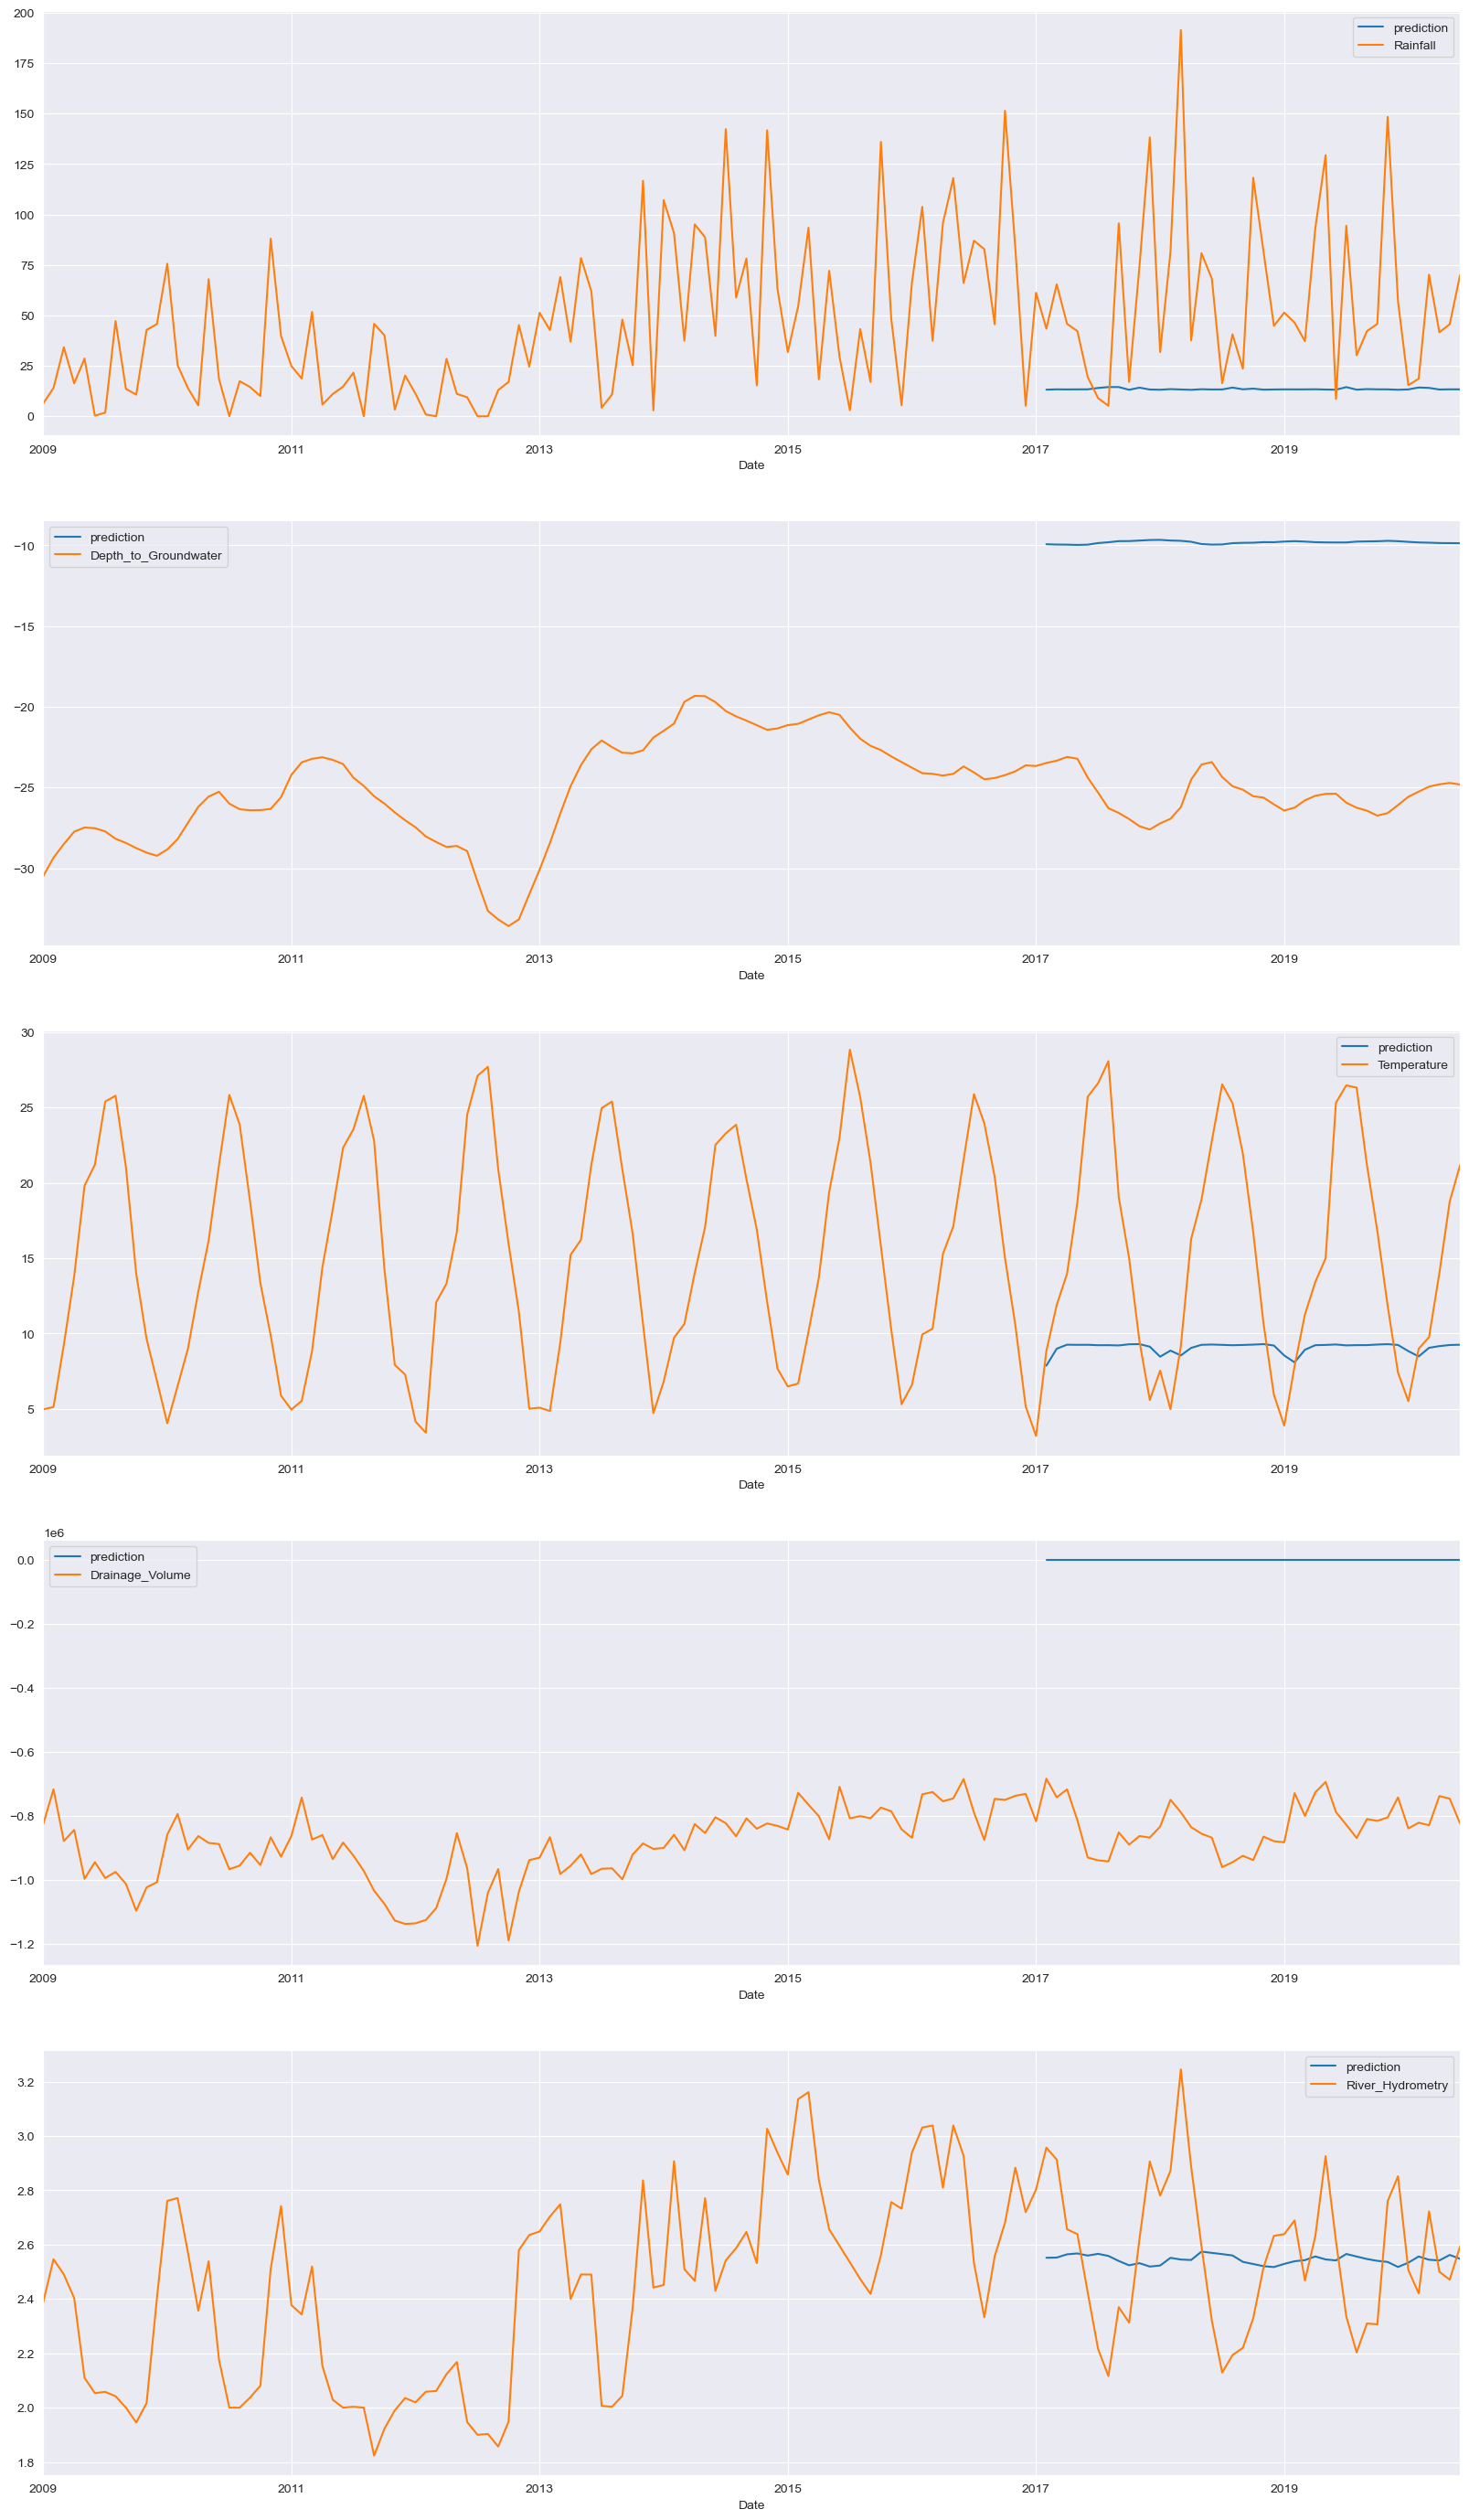

In [61]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 35))
for i in range(5):
    saved_df.iloc[-1000:,i].plot(ax = ax[i], label='prediction', legend=True)
    df.iloc[-1000:,i].plot(ax = ax[i], legend=True)
plt.show()